In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
from collections import defaultdict, deque
from functools import partial

class Prisoner():
  def __init__(self, strategy):
    self.strategy = strategy
    self.rewards = 0
    self.next_strategy = strategy
    # Memory of last 3 turns
    self.memory = defaultdict(partial(deque, maxlen=3))
    self.last_action = defaultdict(lambda: None)

  def calculate_reward(self, game_rules, neighbour_prisoner):
      neighbour_prisoner_decision = neighbour_prisoner.strategy.decide(neighbour_prisoner.memory[self], neighbour_prisoner.last_action[self])
      decision = self.strategy.decide(self.memory[neighbour_prisoner], self.last_action[neighbour_prisoner])
      reward, neighbour_prisoner_reward = game_rules.get_reward(decision, neighbour_prisoner_decision)
      self.rewards += reward
      neighbour_prisoner.rewards += neighbour_prisoner_reward
      self.memory[neighbour_prisoner].append(neighbour_prisoner_decision)
      self.last_action[neighbour_prisoner] = decision
      neighbour_prisoner.memory[self].append(decision)
      neighbour_prisoner.last_action[self] = neighbour_prisoner_decision

  
  def reset(self):
    self.rewards = 0
    self.strategy = self.next_strategy

In [3]:
from enum import Enum
class Action(Enum):
  COOPERATE = 1
  DEFECT = 2

In [4]:
class SimpleGameRules():
  def __init__(self, R, S, T, P):
    self.R = R # Reward
    self.S = S # Sucker's payoff
    self.T = T # Temptation
    self.P = P # Punishment
    if R <= (S + T)/2:
      raise ValueError('R must be bigger than (S + T)/2')
  
  def get_reward(self, action1, action2):
    if action1 is Action.COOPERATE and action2 is Action.COOPERATE:
      return self.R, self.R
    elif action1 is Action.COOPERATE and action2 is Action.DEFECT:
      return self.S, self.T
    elif action1 is Action.DEFECT and action2 is Action.COOPERATE:
      return self.T, self.S
    elif action1 is Action.DEFECT and action2 is Action.DEFECT:
      return self.P, self.P

In [5]:
class CooperateStrategy():
  def __init__(self):
    self.color = "green"

  def decide(self, _memory, _last_action_reward):
    return Action.COOPERATE
  
  def __str__(self):
    return "cooperate"

In [6]:
class DefectStrategy():
  def __init__(self):
    self.color = "red"

  def decide(self, _memory, _last_action_reward):
    return Action.DEFECT
  
  def __str__(self):
    return "defect"

In [7]:
class TitForTatStrategy():
  def __init__(self):
    self.color = "yellow"

  def decide(self, memory, _last_action_reward):
    if len(memory) == 0:
      return Action.COOPERATE
    else:
      return memory[-1]
  
  def __str__(self):
    return "tit_for_tat"

In [8]:
class PavlovStrategy():
  # win-stay, lose-switch
  def __init__(self):
    self.color = "blue"
    self.default_action = Action.COOPERATE
  
  def decide(self, memory, last_action):
    if last_action is not None:
      if last_action == memory[-1]:
        return Action.COOPERATE
      else:
        return Action.DEFECT
    else:
      return Action.COOPERATE
  
  def __str__(self):
    return "pavlov"

In [9]:
class RandomStrategy():
  def __init__(self):
    self.color = "pink"

  def decide(self, _memory, _last_action_reward):
    return random.choice([Action.COOPERATE, Action.DEFECT])
  
  def __str__(self):
    return "random"

In [34]:
import random
import numpy as np

class World():
  def __init__(self, game_rules, G, iterations=10):
    self.game_rules = game_rules
    self.iterations = iterations
    self.G = G
    self.strategy_counts = defaultdict(lambda: [0])
    self.update_strategy_counts()
    self.pos = None 

  def start(self, simulations):
    for _ in range(simulations):
      self.play()

  def play(self):
    self.reset()
    for i in range(self.iterations):
      self.simulate_game()
    self.normalise_neighbours_rewards_by_degree()
    self.swap_for_best_strategies()
    self.update_strategy_counts()

  def get_prisoner_neighbours(self, prisoner):
    return self.G.neighbors(prisoner)

  def reset(self):
    for prisoner in self.G.nodes():
      prisoner.reset()
    
    for k in self.strategy_counts.keys():
      self.strategy_counts[k].append(0)
  
  def update_strategy_counts(self):
    for prisoner in self.G.nodes():
      strategy = prisoner.strategy
      self.strategy_counts[strategy][-1] += 1
  
  def simulate_game(self):
    for prisoner, neighbour_prisoner in self.G.edges():
      prisoner.calculate_reward(self.game_rules, neighbour_prisoner)

  def swap_for_best_strategies(self):
    for prisoner in self.G.nodes():
      neighbour_prisoners = self.get_prisoner_neighbours(prisoner)
      best_reward = prisoner.rewards
      best_strategies = [prisoner.strategy]
      for neighbour_prisoner in neighbour_prisoners:
        if neighbour_prisoner.rewards > best_reward:
          best_reward = neighbour_prisoner.rewards
          best_strategies = [neighbour_prisoner.strategy]
        elif neighbour_prisoner.rewards == best_reward:
          best_strategies.append(neighbour_prisoner.strategy)

      prisoner.next_strategy = random.choice(best_strategies)
  
  def normalise_neighbours_rewards_by_degree(self):
    max_degree = max(self.G.degree, key=lambda x: x[1])[1]
    for prisoner in self.G:
      degree = self.G.degree[prisoner]
      prisoner.rewards = round(max_degree / degree * prisoner.rewards)


  def plot(self, strategies, iteration_nr):
    plt.figure()
    ax = plt.subplot(111)
    color_map = []
    strategies_nodes = {}
    for strategy in strategies:
      strategies_nodes[strategy] = []

    for prisoner in self.G:
      strategies_nodes[prisoner.strategy].append(prisoner)
    pos = nx.get_node_attributes(self.G, 'pos')
    for strategy, nodes in strategies_nodes.items():
      nx.draw_networkx_nodes(self.G, pos=pos, nodelist=nodes,
                       node_color=strategy.color, label=str(strategy),
                       node_size=2)
    plt.title(f"Game: {iteration_nr}")
    filename = f"plots/{i}.png"
    box = ax.get_position()

    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(filename)
    plt.close()
    return filename

  def plot_nx(self, strategies, iteration_nr):
    if self.pos is None:
      self.pos = nx.spring_layout(self.G)
    plt.figure()
    ax = plt.subplot(111)
    color_map = []
    strategies_nodes = {}
    for strategy in strategies:
      strategies_nodes[strategy] = []

    for prisoner in self.G:
      strategies_nodes[prisoner.strategy].append(prisoner)
    for strategy, nodes in strategies_nodes.items():
      d = dict(G.degree(nodes))
      nx.draw_networkx_nodes(self.G, pos=self.pos, nodelist=nodes,
                       node_color=strategy.color, label=str(strategy),
                       node_size=[v * 2 for v in d.values()])
    plt.title(f"Game: {iteration_nr}")
    filename = f"plots/{iteration_nr}.png"
    box = ax.get_position()

    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in lgnd.legendHandles:
      handle.set_sizes([19.0])
    nx.draw_networkx_edges(self.G, pos=self.pos)
    plt.savefig(filename)
    plt.close()
    return filename


  def save_node_stats(self):
    output_file = open("graph_data.csv", "w")
    simulation_length = 1E8

    output_file.write("step")
    for k in self.strategy_counts.keys():
      output_file.write(f";{k}")
      simulation_length = min(simulation_length, len(self.strategy_counts[k]))
    output_file.write("\n")

    for i in range(simulation_length):
      output_file.write(f"{i}")
      for k in self.strategy_counts.keys():
        output_file.write(f";{self.strategy_counts[k][i]}")
      output_file.write("\n")

    output_file.close()

  

In [11]:
!mkdir plots
!mkdir gifs

In [12]:
game_rules = SimpleGameRules(R=3, S=0, T=5, P=1)

1 Graf regularny

In [ ]:
#Building the Grid and the nodes
resolution = 1
length = 100
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

xGrid = np.arange(0, length+1, resolution)
yGrid = np.arange(0, length+1, resolution)
G = nx.Graph()
meshNumber = np.empty((length, length), dtype=object)
# tworzenie wierzcholkow
for i in range(length):
    for j in range(length):
      prisoner = Prisoner(random.choice(strategies))
      G.add_node(prisoner, pos=(
          xGrid[j], yGrid[i]))
      meshNumber[j,i] = prisoner


## neumann neighberhood edges
for i in range(length):
    for j in range(length):
        G.add_edge(meshNumber[j, i], meshNumber[j, (i + 1) % length])
        G.add_edge(meshNumber[j, i], meshNumber[j, (i - 1) % length])
        G.add_edge(meshNumber[j, i], meshNumber[(j + 1) % length, i])
        G.add_edge(meshNumber[j, i], meshNumber[(j - 1) % length, i])

G = G.to_undirected()

# mat[10, 10] = Prisoner(defect_strategy)

In [ ]:
!rm -rf graph_data.csv

In [ ]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot(strategies, 0))
for i in range(200):
  world.play()
  filenames.append(world.plot(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/noumann.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # for filename in set(filenames):
  #   os.remove(filename)


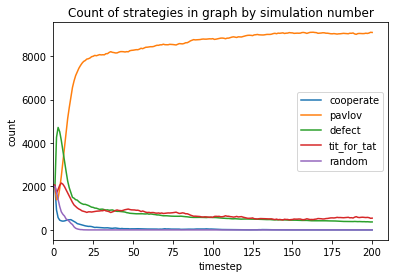

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.set_title('Count of strategies in graph by simulation number')
ax.legend(loc="best")

2. Barabasi graf scale free

In [ ]:
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

G = nx.barabasi_albert_graph(100, 3)
G = nx.relabel_nodes(G, lambda x: Prisoner(random.choice(strategies)))


In [ ]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot_nx(strategies, 0))
for i in range(200):
  world.play()
  filenames.append(world.plot_nx(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/barabasi.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  """for filename in set(filenames):
    os.remove(filename)
"""

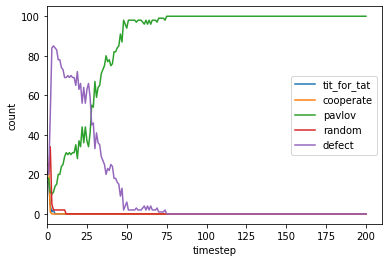

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.legend(loc="best")

3. Karate club graph

In [ ]:
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

G = nx.karate_club_graph()
G = nx.relabel_nodes(G, lambda x: Prisoner(random.choice(strategies)))


In [ ]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot_nx(strategies, 0))
for i in range(50):
  world.play()
  filenames.append(world.plot_nx(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/karate.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  """for filename in set(filenames):
    os.remove(filename)"""


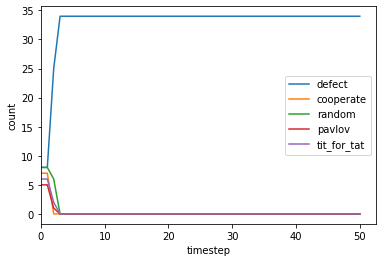

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.legend(loc="best")

4. Atlas

In [ ]:
GraphMatcher = nx.isomorphism.vf2userfunc.GraphMatcher

def atlas6():
    """Return the atlas of all connected graphs with at most 6 nodes"""

    Atlas = nx.graph_atlas_g()[3:209]  # 0, 1, 2 => no edges. 208 is last 6 node graph
    U = nx.Graph()  # graph for union of all graphs in atlas
    for G in Atlas:
        # check if connected
        if nx.number_connected_components(G) == 1:
            # check if isomorphic to a previous graph
            if not GraphMatcher(U, G).subgraph_is_isomorphic():
                U = nx.disjoint_union(U, G)
    return U

In [ ]:
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

G = atlas6()
G = nx.relabel_nodes(G, lambda x: Prisoner(random.choice(strategies)))

In [ ]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot_nx(strategies, 0))
for i in range(20):
  world.play()
  filenames.append(world.plot_nx(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/atlas.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
"""  for filename in set(filenames):
    os.remove(filename)"""

'  for filename in set(filenames):\n    os.remove(filename)'

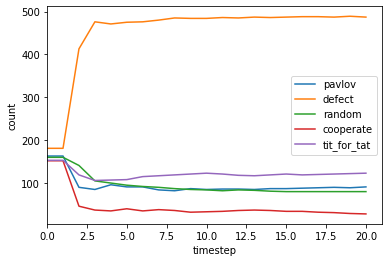

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.legend(loc="best")

5. Small world

In [ ]:
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

G = nx.watts_strogatz_graph(n = 100, k = 4, p = 0.5)
G = nx.relabel_nodes(G, lambda x: Prisoner(random.choice(strategies)))

In [ ]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot_nx(strategies, 0))
for i in range(100):
  world.play()
  filenames.append(world.plot_nx(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/small_world.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
"""  for filename in set(filenames):
    os.remove(filename)"""

'  for filename in set(filenames):\n    os.remove(filename)'

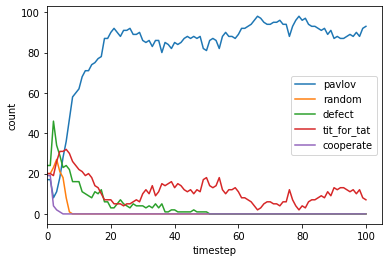

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.legend(loc="best")

6. Bitcoin Alpha trust weighted signed network

https://snap.stanford.edu/data/soc-sign-bitcoin-alpha.html

In [13]:
!wget https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz

--2022-01-07 20:21:24--  https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149480 (146K) [application/x-gzip]
Saving to: ‘soc-sign-bitcoinalpha.csv.gz’

soc-sign-bitcoinalp 100%[===================>] 145.98K  --.-KB/s    in 0.1s    

2022-01-07 20:21:24 (1.25 MB/s) - ‘soc-sign-bitcoinalpha.csv.gz’ saved [149480/149480]



In [14]:
!gzip -d soc-sign-bitcoinalpha.csv.gz

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
cooperate_strategy = CooperateStrategy()
defect_strategy = DefectStrategy()
tit_for_tat_strategy = TitForTatStrategy()
pavlov_strategy = PavlovStrategy()
random_strategy = RandomStrategy()
strategies = [cooperate_strategy, defect_strategy, tit_for_tat_strategy, 
              pavlov_strategy, random_strategy]

df = pd.read_csv("soc-sign-bitcoinalpha.csv", names=["source", "target", "rating", "time"])
G = nx.from_pandas_edgelist(df, "source", "target")
G = nx.relabel_nodes(G, lambda x: Prisoner(random.choice(strategies)))
G = G.to_undirected()

In [36]:
components = [comp for comp in sorted(nx.connected_components(G), key=len, reverse=True)]
biggest_component = components[0]

In [37]:
G = G.subgraph(biggest_component).copy()

In [38]:
import imageio
import os

filenames = []
world = World(game_rules, G)
filenames.append(world.plot_nx(strategies, 0))
for i in range(200):
  world.play()
  filenames.append(world.plot_nx(strategies, i + 1))
world.save_node_stats()

with imageio.get_writer(f"gifs/bitcoin_alpha.gif", mode='I') as writer:
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
"""  for filename in set(filenames):
    os.remove(filename)"""

'  for filename in set(filenames):\n    os.remove(filename)'

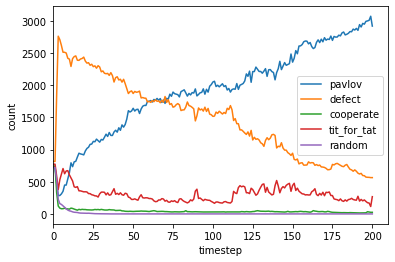

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("graph_data.csv", sep=";", index_col=0)
fig, ax = plt.subplots()

for strategy in df.columns:
  column = df[strategy]
  x = range(len(column))
  ax.plot(x, column, label=strategy)

ax.set_xlabel("timestep")
ax.set_ylabel("count")
ax.set_xlim(left=0)
ax.legend(loc="best")